# La baseline 

In [7]:
import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import matplotlib.gridspec as gridspec
import seaborn # advanced data plotting
from sklearn import preprocessing # basic ML models
# import scipy # scientific computing library
from tqdm import tqdm #progress bar

import time
import os
import pickle

import torch

In [8]:
torch.cuda.is_available()
device = "cuda:0" if torch.cuda.is_available() else "cpu" #0 indicates the GPU you gonna use 
print(f"Using {device} device")

Using cuda:0 device


In [9]:
from torchvision import datasets
from torchvision import transforms


transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
# set transformation

traindata = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testdata = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

AxesImage(size=(28, 28))
60000
10000


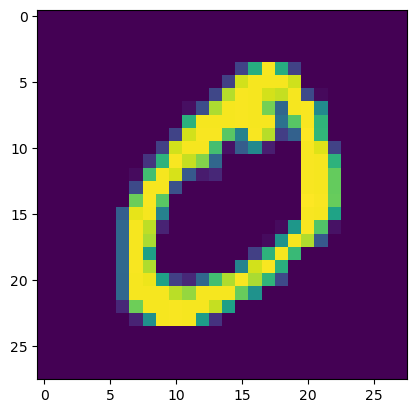

In [10]:
print(plt.imshow(traindata[1][0].view(28,28)))
print(len(traindata))
print(len(testdata))

In [11]:
from sklearn.model_selection import train_test_split
random_state = 2023 #for reproductible results
train_indices, labeled_indices = train_test_split(list(range(len(traindata.targets))), test_size=100, stratify=traindata.targets,random_state=random_state)

In [12]:
trainset = torch.utils.data.Subset(traindata, train_indices)
labeledset = torch.utils.data.Subset(traindata, labeled_indices)

In [13]:
trainset[1][0].shape

torch.Size([1, 28, 28])

In [70]:
batch_size_labeled = 50
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
labeledloader = torch.utils.data.DataLoader(labeledset, batch_size=batch_size_labeled,
                                         shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): #must correspond to the previous model set, comme un héritage
    def __init__(self):
      super(Net, self).__init__()  #pour surpasser l'initialisation de la classe nn.Module
      # to fill
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same") 
      # the three arguments in_channels,out_channels,kernel_size must be filled, the others are optionnal and have default values
      # out_channels correspond to the number of filters
      # if heigth=width in the kernel size, just set one value
      # stride is set to 0 by default
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same") 
      self.pool = nn.MaxPool2d(kernel_size= 2) # pooling layer
      self.dp1 = nn.Dropout(p=0.25) # probability of an element to be set to 0.
      #self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=512) # fully connected layer
      self.fc1 = nn.Linear(in_features= 32 * 14 * 14, out_features=512)
      self.dp2 = nn.Dropout(p=0.5) # probability of an element to be set to 0.
      self.fc2 = nn.Linear(in_features= 512, out_features=10) # fully connected layer


    def forward(self, x):
      # to fill with sequential pass through the model
      # i.e the input data 'x' must pass sequentially through the layers defined in '__init__'
      x = F.relu(self.conv1(x))
      x = self.pool(F.relu(self.conv2(x)))
      #x = self.dp1(x)
      x = torch.flatten(x,1) #flaten all dimensions except batch
      #x = self.dp2(F.relu(self.fc1(x)))
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x 

In [11]:
model = Net().to(device) 
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [67]:
import torch.optim as optim

output_fn = torch.nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

NameError: name 'model' is not defined

In [69]:
def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true,y_pred))) / y_true.shape[0]

In [14]:
from tqdm import tqdm


def train_func(train_loader, val_loader, model=None, epochs:int=None, optimizer=None, criterion=None):

  loss_valid,acc_valid =[],[]
  loss_train,acc_train =[],[]

  for epoch in tqdm(range(epochs)):

    # Training
    model.train()
    running_loss = 0.0
    for idx,batch in enumerate(train_loader):

      # get the inputs; batch is a list of [inputs, labels]
      inputs,labels=batch
      inputs=inputs.to(device) #train on GPU
      labels=labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      out = model(x=inputs)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()

    # compute loss and accuracy after an epoch on the train and valid set
    model.eval()  
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
      idx = 0
      for batch in val_loader:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction                       
          ground_truth = labels.detach().cpu().numpy()
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item())) 
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

      acc_valid.append(get_accuracy(ground_truth,t_out))
      loss_valid.append(np.mean(t_loss))

    with torch.no_grad():
      idx = 0
      for batch in train_loader:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out=t_out.argmax(axis=1)
          ground_truth = labels.detach().cpu().numpy()
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item()))
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))   
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

    acc_train.append(get_accuracy(ground_truth,t_out))
    loss_train.append(np.mean(t_loss))

    print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
      '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1,epochs,loss_train[epoch],acc_train[epoch],loss_valid[epoch],acc_valid[epoch]))
    

  return model, (loss_train, acc_train, loss_valid, acc_valid)

In [190]:
epochs = 10

args_train = {"train_loader" : labeledloader,
              "val_loader" : testloader,
              "model" : model,
              "epochs" : epochs,
              "optimizer" : optimizer,
              "criterion" : criterion}

net, (loss_train, acc_train, loss_valid, acc_valid) = train_func(**args_train)

  5%|▌         | 1/20 [00:02<00:40,  2.11s/it]

| Epoch: 1/20 | Train: Loss 5.8189 Accuracy : 0.1400 | Val: Loss 6.2400 Accuracy : 0.1178



 10%|█         | 2/20 [00:04<00:37,  2.07s/it]

| Epoch: 2/20 | Train: Loss 1.4906 Accuracy : 0.6800 | Val: Loss 1.7558 Accuracy : 0.4596



 15%|█▌        | 3/20 [00:06<00:34,  2.05s/it]

| Epoch: 3/20 | Train: Loss 0.5859 Accuracy : 0.8600 | Val: Loss 1.1314 Accuracy : 0.6478



 20%|██        | 4/20 [00:08<00:33,  2.08s/it]

| Epoch: 4/20 | Train: Loss 0.1525 Accuracy : 0.9600 | Val: Loss 0.9734 Accuracy : 0.7516



 25%|██▌       | 5/20 [00:10<00:30,  2.06s/it]

| Epoch: 5/20 | Train: Loss 0.0288 Accuracy : 0.9900 | Val: Loss 1.1312 Accuracy : 0.7648



 30%|███       | 6/20 [00:12<00:28,  2.05s/it]

| Epoch: 6/20 | Train: Loss 0.0644 Accuracy : 0.9900 | Val: Loss 1.7208 Accuracy : 0.7293



 35%|███▌      | 7/20 [00:14<00:26,  2.05s/it]

| Epoch: 7/20 | Train: Loss 0.0034 Accuracy : 1.0000 | Val: Loss 1.7424 Accuracy : 0.7746



 40%|████      | 8/20 [00:16<00:24,  2.03s/it]

| Epoch: 8/20 | Train: Loss 0.0068 Accuracy : 1.0000 | Val: Loss 2.1332 Accuracy : 0.7545



 45%|████▌     | 9/20 [00:18<00:22,  2.02s/it]

| Epoch: 9/20 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 2.3808 Accuracy : 0.7540



 50%|█████     | 10/20 [00:20<00:20,  2.02s/it]

| Epoch: 10/20 | Train: Loss 0.0005 Accuracy : 1.0000 | Val: Loss 2.7121 Accuracy : 0.7475



 55%|█████▌    | 11/20 [00:22<00:18,  2.03s/it]

| Epoch: 11/20 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 2.9541 Accuracy : 0.7469



 60%|██████    | 12/20 [00:24<00:16,  2.01s/it]

| Epoch: 12/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 3.1651 Accuracy : 0.7480



 65%|██████▌   | 13/20 [00:26<00:14,  2.01s/it]

| Epoch: 13/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 3.3670 Accuracy : 0.7480



 70%|███████   | 14/20 [00:28<00:12,  2.02s/it]

| Epoch: 14/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 3.5571 Accuracy : 0.7456



 75%|███████▌  | 15/20 [00:30<00:10,  2.03s/it]

| Epoch: 15/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 3.7317 Accuracy : 0.7435



 80%|████████  | 16/20 [00:32<00:08,  2.05s/it]

| Epoch: 16/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 3.8851 Accuracy : 0.7411



 85%|████████▌ | 17/20 [00:35<00:06,  2.33s/it]

| Epoch: 17/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 4.0173 Accuracy : 0.7396



 90%|█████████ | 18/20 [00:38<00:04,  2.37s/it]

| Epoch: 18/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 4.1248 Accuracy : 0.7390



 95%|█████████▌| 19/20 [00:40<00:02,  2.27s/it]

| Epoch: 19/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 4.2071 Accuracy : 0.7388



100%|██████████| 20/20 [00:42<00:00,  2.11s/it]

| Epoch: 20/20 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 4.2647 Accuracy : 0.7379



To save the model

In [ ]:
#PATH = './basic_model.pth'
#torch.save(net.state_dict(), PATH)

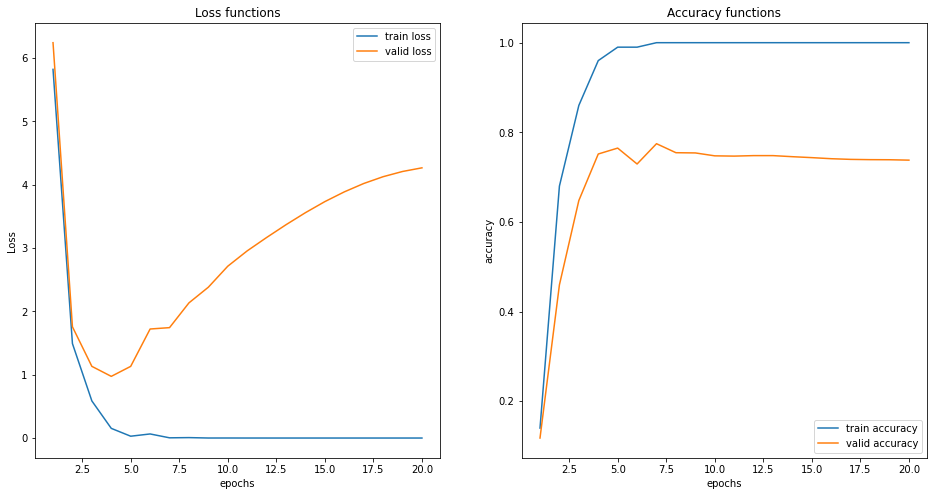

In [192]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(range(1,epochs + 1), loss_train, label="train loss" )
plt.plot(range(1, epochs +1), loss_valid, label="valid loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Loss functions")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,epochs + 1), acc_train, label="train accuracy" )
plt.plot(range(1, epochs +1), acc_valid, label="valid accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy functions")
plt.legend()

#plt.savefig("Metrics functins basic model.png")
plt.show()

  8%|██████▉                                                                            | 1/12 [00:05<01:00,  5.49s/it]

| Epoch: 1/12 | Train: Loss 2.3017 Accuracy : 0.1000 | Val: Loss 2.3033 Accuracy : 0.1010



 17%|█████████████▊                                                                     | 2/12 [00:10<00:53,  5.31s/it]

| Epoch: 2/12 | Train: Loss 2.3003 Accuracy : 0.1000 | Val: Loss 2.3042 Accuracy : 0.0980



 25%|████████████████████▊                                                              | 3/12 [00:15<00:46,  5.22s/it]

| Epoch: 3/12 | Train: Loss 2.2978 Accuracy : 0.1000 | Val: Loss 2.3042 Accuracy : 0.0980



 33%|███████████████████████████▋                                                       | 4/12 [00:20<00:41,  5.20s/it]

| Epoch: 4/12 | Train: Loss 2.2952 Accuracy : 0.1000 | Val: Loss 2.3043 Accuracy : 0.0980



 42%|██████████████████████████████████▌                                                | 5/12 [00:26<00:36,  5.23s/it]

| Epoch: 5/12 | Train: Loss 2.2930 Accuracy : 0.1000 | Val: Loss 2.3047 Accuracy : 0.1032



 50%|█████████████████████████████████████████▌                                         | 6/12 [00:31<00:31,  5.27s/it]

| Epoch: 6/12 | Train: Loss 2.2911 Accuracy : 0.1000 | Val: Loss 2.3055 Accuracy : 0.1032



 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:37<00:26,  5.35s/it]

| Epoch: 7/12 | Train: Loss 2.2897 Accuracy : 0.1000 | Val: Loss 2.3068 Accuracy : 0.1032



 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:42<00:21,  5.46s/it]

| Epoch: 8/12 | Train: Loss 2.2886 Accuracy : 0.1000 | Val: Loss 2.3082 Accuracy : 0.1032



 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:48<00:16,  5.50s/it]

| Epoch: 9/12 | Train: Loss 2.2879 Accuracy : 0.1000 | Val: Loss 2.3096 Accuracy : 0.1032



 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:54<00:11,  5.77s/it]

| Epoch: 10/12 | Train: Loss 2.2875 Accuracy : 0.1000 | Val: Loss 2.3109 Accuracy : 0.1032



 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [01:00<00:05,  5.75s/it]

| Epoch: 11/12 | Train: Loss 2.2873 Accuracy : 0.1000 | Val: Loss 2.3119 Accuracy : 0.1032



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:05<00:00,  5.49s/it]

| Epoch: 12/12 | Train: Loss 2.2871 Accuracy : 0.1000 | Val: Loss 2.3127 Accuracy : 0.1032

Pour un batch_size égale à 16 on a


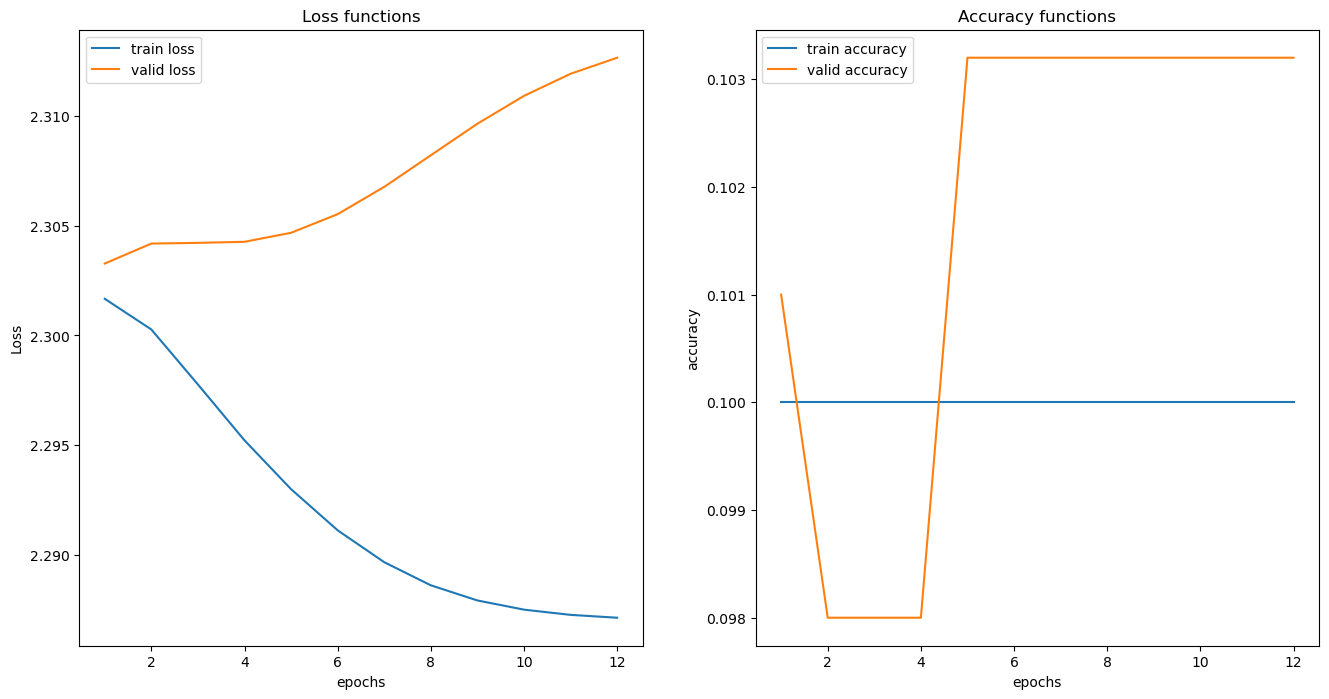

  8%|██████▉                                                                            | 1/12 [00:05<00:58,  5.35s/it]

| Epoch: 1/12 | Train: Loss 2.1541 Accuracy : 0.3000 | Val: Loss 2.2181 Accuracy : 0.2843



 17%|█████████████▊                                                                     | 2/12 [00:10<00:52,  5.28s/it]

| Epoch: 2/12 | Train: Loss 1.3994 Accuracy : 0.4300 | Val: Loss 1.9697 Accuracy : 0.3506



 25%|████████████████████▊                                                              | 3/12 [00:15<00:46,  5.15s/it]

| Epoch: 3/12 | Train: Loss 0.6872 Accuracy : 0.7800 | Val: Loss 1.3067 Accuracy : 0.5605



 33%|███████████████████████████▋                                                       | 4/12 [00:20<00:41,  5.16s/it]

| Epoch: 4/12 | Train: Loss 0.3550 Accuracy : 0.8800 | Val: Loss 1.6369 Accuracy : 0.5910



 42%|██████████████████████████████████▌                                                | 5/12 [00:25<00:35,  5.03s/it]

| Epoch: 5/12 | Train: Loss 0.1355 Accuracy : 0.9400 | Val: Loss 1.9299 Accuracy : 0.6143



 50%|█████████████████████████████████████████▌                                         | 6/12 [00:30<00:29,  4.99s/it]

| Epoch: 6/12 | Train: Loss 0.0414 Accuracy : 0.9800 | Val: Loss 1.9301 Accuracy : 0.6700



 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:35<00:24,  4.93s/it]

| Epoch: 7/12 | Train: Loss 0.0347 Accuracy : 0.9900 | Val: Loss 2.2233 Accuracy : 0.6521



 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:39<00:19,  4.85s/it]

| Epoch: 8/12 | Train: Loss 0.0214 Accuracy : 0.9900 | Val: Loss 2.4182 Accuracy : 0.6619



 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:45<00:14,  4.94s/it]

| Epoch: 9/12 | Train: Loss 0.0237 Accuracy : 0.9900 | Val: Loss 2.3789 Accuracy : 0.6607



 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:50<00:10,  5.16s/it]

| Epoch: 10/12 | Train: Loss 0.0450 Accuracy : 0.9800 | Val: Loss 2.5749 Accuracy : 0.6035



 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:56<00:05,  5.28s/it]

| Epoch: 11/12 | Train: Loss 0.0190 Accuracy : 0.9900 | Val: Loss 2.4618 Accuracy : 0.6299



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:01<00:00,  5.15s/it]

| Epoch: 12/12 | Train: Loss 0.0095 Accuracy : 1.0000 | Val: Loss 2.4527 Accuracy : 0.6282

Pour un batch_size égale à 32 on a


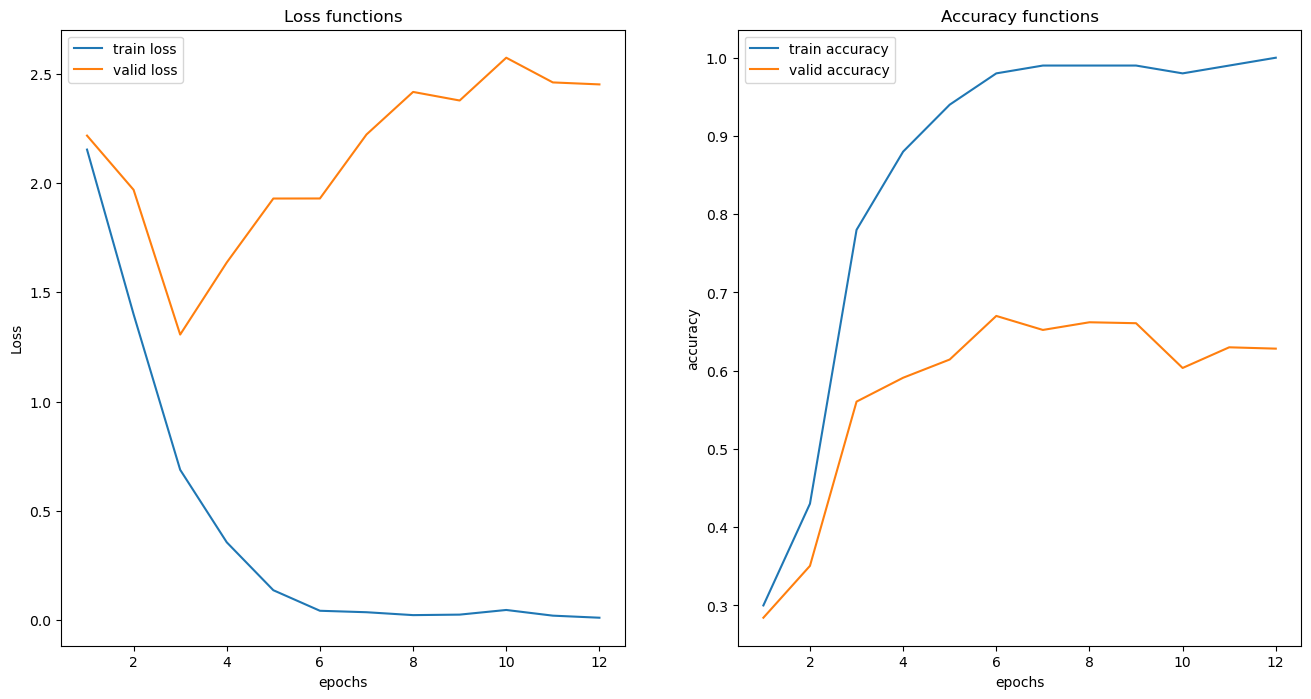

  8%|██████▉                                                                            | 1/12 [00:04<00:48,  4.40s/it]

| Epoch: 1/12 | Train: Loss 7.4219 Accuracy : 0.1000 | Val: Loss 7.5119 Accuracy : 0.0982



 17%|█████████████▊                                                                     | 2/12 [00:08<00:41,  4.18s/it]

| Epoch: 2/12 | Train: Loss 2.2799 Accuracy : 0.2200 | Val: Loss 2.3002 Accuracy : 0.1765



 25%|████████████████████▊                                                              | 3/12 [00:12<00:37,  4.17s/it]

| Epoch: 3/12 | Train: Loss 2.0879 Accuracy : 0.3700 | Val: Loss 2.1694 Accuracy : 0.3075



 33%|███████████████████████████▋                                                       | 4/12 [00:16<00:33,  4.24s/it]

| Epoch: 4/12 | Train: Loss 1.5943 Accuracy : 0.4800 | Val: Loss 1.8601 Accuracy : 0.3715



 42%|██████████████████████████████████▌                                                | 5/12 [00:21<00:30,  4.31s/it]

| Epoch: 5/12 | Train: Loss 0.8411 Accuracy : 0.7400 | Val: Loss 1.2663 Accuracy : 0.5923



 50%|█████████████████████████████████████████▌                                         | 6/12 [00:25<00:25,  4.27s/it]

| Epoch: 6/12 | Train: Loss 0.4169 Accuracy : 0.8700 | Val: Loss 1.1537 Accuracy : 0.6822



 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:29<00:21,  4.21s/it]

| Epoch: 7/12 | Train: Loss 0.2822 Accuracy : 0.9100 | Val: Loss 1.4152 Accuracy : 0.6976



 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:33<00:16,  4.16s/it]

| Epoch: 8/12 | Train: Loss 0.2172 Accuracy : 0.9300 | Val: Loss 1.8510 Accuracy : 0.6857



 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:38<00:12,  4.31s/it]

| Epoch: 9/12 | Train: Loss 0.0505 Accuracy : 0.9800 | Val: Loss 1.6690 Accuracy : 0.7150



 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:42<00:08,  4.17s/it]

| Epoch: 10/12 | Train: Loss 0.1261 Accuracy : 0.9500 | Val: Loss 2.2800 Accuracy : 0.6634



 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:46<00:04,  4.10s/it]

| Epoch: 11/12 | Train: Loss 0.0130 Accuracy : 1.0000 | Val: Loss 2.1484 Accuracy : 0.6987



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:50<00:00,  4.18s/it]

| Epoch: 12/12 | Train: Loss 0.0162 Accuracy : 1.0000 | Val: Loss 2.5559 Accuracy : 0.6959

Pour un batch_size égale à 64 on a


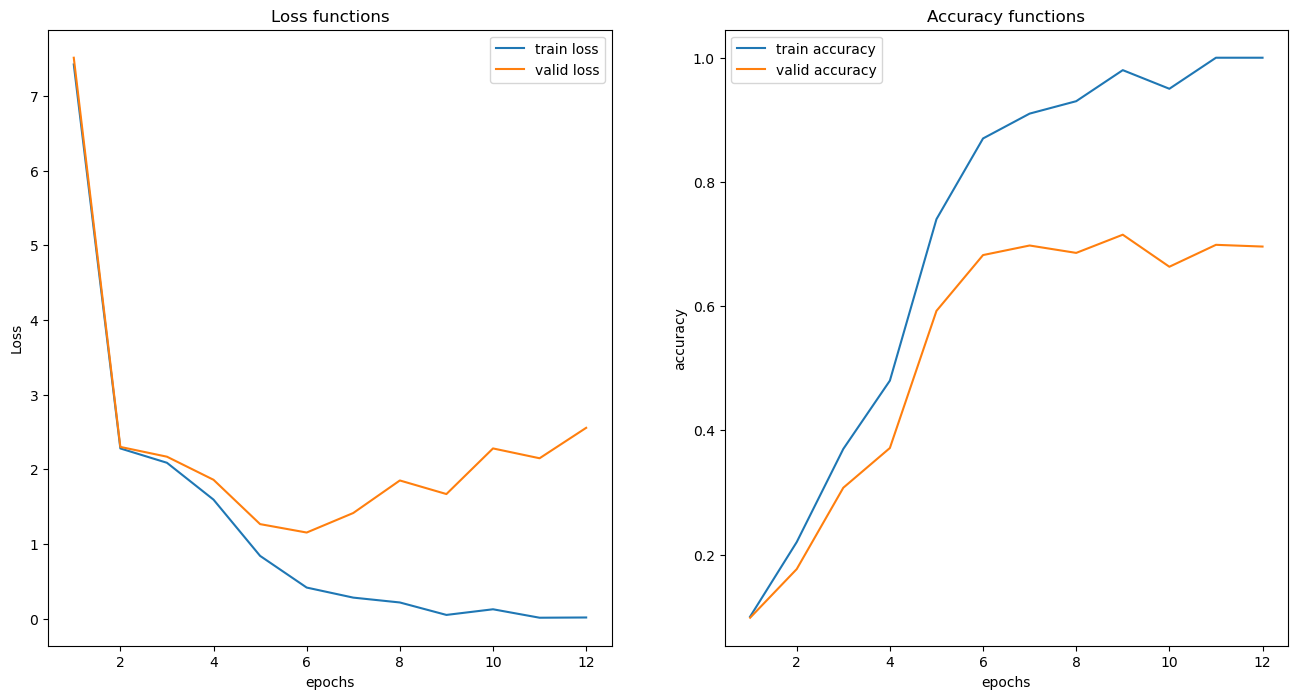

In [19]:
epochs = 12

for batch_size in [16,32,64]:
    labeledloader = torch.utils.data.DataLoader(labeledset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
    testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
    
    model = Net().to(device) 
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    args_train = {"train_loader" : labeledloader,
              "val_loader" : testloader,
              "model" : model,
              "epochs" : epochs,
              "optimizer" : optimizer,
              "criterion" : criterion}
    net, (loss_train, acc_train, loss_valid, acc_valid) = train_func(**args_train)
    
    print(f"Pour un batch_size égale à {batch_size} on a")
    
    plt.figure(figsize=(16,8))

    plt.subplot(1,2,1)
    plt.plot(range(1,epochs + 1), loss_train, label="train loss" )
    plt.plot(range(1, epochs +1), loss_valid, label="valid loss")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.title("Loss functions")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1,epochs + 1), acc_train, label="train accuracy" )
    plt.plot(range(1, epochs +1), acc_valid, label="valid accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Accuracy functions")
    plt.legend()

    #plt.savefig("Metrics functins basic model.png")
    plt.show()

# Transfert learning

In [31]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True)
#PATH = './resnet18_default.pth'
#torch.save(resnet.state_dict(), PATH)

In [36]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# We must put all layers 'require_grad' to false first
for name, param in resnet.named_parameters():
    param.requires_grad = False

In [22]:
# update the final layer
# the final layer 'require_grad' should be on True
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

In [23]:
# to device
resnet = resnet.to(device)

In [24]:
output_fn = nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()

In [27]:
resnet.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [25]:
batch_size = 32

labeledloader = torch.utils.data.DataLoader(labeledset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
    
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
    
args_train = {"train_loader" : labeledloader,
              "val_loader" : testloader,
              "model" : resnet,
              "epochs" : epochs,
              "optimizer" : optimizer,
              "criterion" : criterion}
net, (loss_train, acc_train, loss_valid, acc_valid) = train_func(**args_train)
    
print(f"Pour un batch_size égale à {batch_size} on a")
    
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(range(1,epochs + 1), loss_train, label="train loss" )
plt.plot(range(1, epochs +1), loss_valid, label="valid loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Loss functions")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,epochs + 1), acc_train, label="train accuracy" )
plt.plot(range(1, epochs +1), acc_valid, label="valid accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy functions")
plt.legend()

#plt.savefig("Metrics functins basic model.png")
plt.show()  

  0%|                                                                                           | 0/12 [00:01<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [24]:
import cv2

In [18]:
image = traindata[1]

In [41]:
img,label = image

In [80]:
img.shape

torch.Size([1, 28, 28])

In [84]:
test3 = torch.cat((img,img,img), dim=0)

In [85]:
test3.shape

torch.Size([3, 28, 28])

In [50]:
test = img.numpy()

In [56]:
test2 = np.concatenate((test,test,test), axis=0)

(3, 28, 28)

-0.6889255

In [32]:
img2 = cv2.resize(img.numpy(),dsize = (3,28,28))

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 3
>  - Can't parse 'dsize'. Expected sequence length 2, got 3


# Test avec 3 channels 

In [73]:
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module): #must correspond to the previous model set, comme un héritage
    def __init__(self):
      super(Net2, self).__init__()  #pour surpasser l'initialisation de la classe nn.Module
      # to fill
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same") 
      # the three arguments in_channels,out_channels,kernel_size must be filled, the others are optionnal and have default values
      # out_channels correspond to the number of filters
      # if heigth=width in the kernel size, just set one value
      # stride is set to 0 by default
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same") 
      self.pool = nn.MaxPool2d(kernel_size= 2) # pooling layer
      self.dp1 = nn.Dropout(p=0.25) # probability of an element to be set to 0.
      #self.fc1 = nn.Linear(in_features= 32 * 16 * 16, out_features=512) # fully connected layer
      self.fc1 = nn.Linear(in_features= 32 * 14 * 14, out_features=512)
      self.dp2 = nn.Dropout(p=0.5) # probability of an element to be set to 0.
      self.fc2 = nn.Linear(in_features= 512, out_features=10) # fully connected layer


    def forward(self, x):
      # to fill with sequential pass through the model
      # i.e the input data 'x' must pass sequentially through the layers defined in '__init__'
      x = F.relu(self.conv1(x))
      x = self.pool(F.relu(self.conv2(x)))
      #x = self.dp1(x)
      x = torch.flatten(x,1) #flaten all dimensions except batch
      #x = self.dp2(F.relu(self.fc1(x)))
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x 

In [74]:
model2 = Net2().to(device) 
print(model2)

Net2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dp1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [75]:
import torch.optim as optim

output_fn = torch.nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

In [90]:
from tqdm import tqdm


def train_func(train_loader, val_loader, model=None, epochs:int=None, optimizer=None, criterion=None):

  loss_valid,acc_valid =[],[]
  loss_train,acc_train =[],[]

  for epoch in tqdm(range(epochs)):

    # Training
    model.train()
    running_loss = 0.0
    for idx,batch in enumerate(train_loader):

      # get the inputs; batch is a list of [inputs, labels]
      inputs,labels=batch
      inputs = torch.cat((inputs,inputs,inputs), dim=1)
      inputs=inputs.to(device) #train on GPU
      labels=labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      out = model(x=inputs)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()

    # compute loss and accuracy after an epoch on the train and valid set
    model.eval()  
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
      idx = 0
      for batch in val_loader:
        inputs,labels=batch
        inputs = torch.cat((inputs,inputs,inputs), dim=1)
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction                       
          ground_truth = labels.detach().cpu().numpy()
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item())) 
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

      acc_valid.append(get_accuracy(ground_truth,t_out))
      loss_valid.append(np.mean(t_loss))

    with torch.no_grad():
      idx = 0
      for batch in train_loader:
        inputs,labels=batch
        inputs = torch.cat((inputs,inputs,inputs), dim=1)
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out=t_out.argmax(axis=1)
          ground_truth = labels.detach().cpu().numpy()
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item()))
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))   
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

    acc_train.append(get_accuracy(ground_truth,t_out))
    loss_train.append(np.mean(t_loss))

    print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
      '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1,epochs,loss_train[epoch],acc_train[epoch],loss_valid[epoch],acc_valid[epoch]))
    

  return model, (loss_train, acc_train, loss_valid, acc_valid)

In [91]:
epochs = 10

args_train = {"train_loader" : labeledloader,
              "val_loader" : testloader,
              "model" : model2,
              "epochs" : epochs,
              "optimizer" : optimizer,
              "criterion" : criterion}

net2, (loss_train, acc_train, loss_valid, acc_valid) = train_func(**args_train)

 10%|████████▎                                                                          | 1/10 [00:05<00:52,  5.86s/it]

| Epoch: 1/10 | Train: Loss 3.2387 Accuracy : 0.1000 | Val: Loss 3.2951 Accuracy : 0.1010



 20%|████████████████▌                                                                  | 2/10 [00:11<00:46,  5.87s/it]

| Epoch: 2/10 | Train: Loss 1.9902 Accuracy : 0.5500 | Val: Loss 2.0703 Accuracy : 0.4221



 30%|████████████████████████▉                                                          | 3/10 [00:16<00:37,  5.39s/it]

| Epoch: 3/10 | Train: Loss 1.0630 Accuracy : 0.6800 | Val: Loss 1.3794 Accuracy : 0.5418



 40%|█████████████████████████████████▏                                                 | 4/10 [00:21<00:31,  5.21s/it]

| Epoch: 4/10 | Train: Loss 0.5112 Accuracy : 0.8300 | Val: Loss 1.0051 Accuracy : 0.6895



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:26<00:25,  5.06s/it]

| Epoch: 5/10 | Train: Loss 0.2800 Accuracy : 0.9200 | Val: Loss 1.3073 Accuracy : 0.6997



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:31<00:20,  5.00s/it]

| Epoch: 6/10 | Train: Loss 0.3929 Accuracy : 0.8200 | Val: Loss 2.0797 Accuracy : 0.5951



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:36<00:14,  4.96s/it]

| Epoch: 7/10 | Train: Loss 0.1277 Accuracy : 0.9800 | Val: Loss 1.4826 Accuracy : 0.7150



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:40<00:09,  4.92s/it]

| Epoch: 8/10 | Train: Loss 0.1290 Accuracy : 0.9600 | Val: Loss 1.5724 Accuracy : 0.7002



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:45<00:04,  4.91s/it]

| Epoch: 9/10 | Train: Loss 0.0574 Accuracy : 0.9800 | Val: Loss 1.5901 Accuracy : 0.7074



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.07s/it]

| Epoch: 10/10 | Train: Loss 0.0244 Accuracy : 1.0000 | Val: Loss 1.4949 Accuracy : 0.7307



In [ ]:
## Avec Resnet maintenant 

In [115]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True)
#PATH = './resnet18_default.pth'
#torch.save(resnet.state_dict(), PATH)

C:\Users\skinz\anaconda3\envs\Deep_learning_course\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\skinz\anaconda3\envs\Deep_learning_course\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [99]:
# We must put all layers 'require_grad' to false first
for name, param in resnet.named_parameters():
    param.requires_grad = False

In [100]:
# update the final layer
# the final layer 'require_grad' should be on True
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

In [101]:
# to device
resnet = resnet.to(device)

In [127]:
resnet.conv1.weight.shape

torch.Size([64, 3, 7, 7])

In [134]:
img_rgb = torch.cat((img,img,img), axis = 0)

In [135]:
img_rgb.shape

torch.Size([3, 28, 28])

In [137]:
resnet.conv1(img_rgb).shape

torch.Size([64, 14, 14])

In [139]:
resnet.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [102]:
output_fn = nn.Softmax(dim=1)
criterion = nn.CrossEntropyLoss()

In [103]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
epochs = 30
    
args_train = {"train_loader" : labeledloader,
              "val_loader" : testloader,
              "model" : resnet,
              "epochs" : epochs,
              "optimizer" : optimizer,
              "criterion" : criterion}
net, (loss_train, acc_train, loss_valid, acc_valid) = train_func(**args_train)

  3%|██▊                                                                                | 1/30 [00:06<03:20,  6.91s/it]

| Epoch: 1/30 | Train: Loss 2.3117 Accuracy : 0.0900 | Val: Loss 2.3139 Accuracy : 0.0851



  7%|█████▌                                                                             | 2/30 [00:13<03:01,  6.47s/it]

| Epoch: 2/30 | Train: Loss 2.2800 Accuracy : 0.1200 | Val: Loss 2.2861 Accuracy : 0.1413



 10%|████████▎                                                                          | 3/30 [00:19<02:52,  6.41s/it]

| Epoch: 3/30 | Train: Loss 2.2457 Accuracy : 0.2100 | Val: Loss 2.2498 Accuracy : 0.2031



 13%|███████████                                                                        | 4/30 [00:25<02:44,  6.33s/it]

| Epoch: 4/30 | Train: Loss 2.2071 Accuracy : 0.2300 | Val: Loss 2.2104 Accuracy : 0.2310



 17%|█████████████▊                                                                     | 5/30 [00:31<02:38,  6.35s/it]

| Epoch: 5/30 | Train: Loss 2.1678 Accuracy : 0.2600 | Val: Loss 2.1725 Accuracy : 0.2512



 20%|████████████████▌                                                                  | 6/30 [00:38<02:31,  6.31s/it]

| Epoch: 6/30 | Train: Loss 2.1212 Accuracy : 0.2900 | Val: Loss 2.1363 Accuracy : 0.2747



 23%|███████████████████▎                                                               | 7/30 [00:44<02:25,  6.32s/it]

| Epoch: 7/30 | Train: Loss 2.0738 Accuracy : 0.2900 | Val: Loss 2.1000 Accuracy : 0.2978



 27%|██████████████████████▏                                                            | 8/30 [00:50<02:19,  6.35s/it]

| Epoch: 8/30 | Train: Loss 2.0247 Accuracy : 0.2800 | Val: Loss 2.0640 Accuracy : 0.3170



 30%|████████████████████████▉                                                          | 9/30 [00:57<02:12,  6.31s/it]

| Epoch: 9/30 | Train: Loss 1.9782 Accuracy : 0.3300 | Val: Loss 2.0306 Accuracy : 0.3302



 33%|███████████████████████████▎                                                      | 10/30 [01:03<02:05,  6.28s/it]

| Epoch: 10/30 | Train: Loss 1.9310 Accuracy : 0.3700 | Val: Loss 2.0027 Accuracy : 0.3412



 37%|██████████████████████████████                                                    | 11/30 [01:09<01:59,  6.28s/it]

| Epoch: 11/30 | Train: Loss 1.8926 Accuracy : 0.3700 | Val: Loss 1.9810 Accuracy : 0.3480



 40%|████████████████████████████████▊                                                 | 12/30 [01:17<02:00,  6.69s/it]

| Epoch: 12/30 | Train: Loss 1.8556 Accuracy : 0.4100 | Val: Loss 1.9668 Accuracy : 0.3523



 43%|███████████████████████████████████▌                                              | 13/30 [01:25<02:01,  7.17s/it]

| Epoch: 13/30 | Train: Loss 1.8233 Accuracy : 0.4300 | Val: Loss 1.9603 Accuracy : 0.3533



 47%|██████████████████████████████████████▎                                           | 14/30 [01:33<01:58,  7.40s/it]

| Epoch: 14/30 | Train: Loss 1.7937 Accuracy : 0.4400 | Val: Loss 1.9610 Accuracy : 0.3516



 50%|█████████████████████████████████████████                                         | 15/30 [01:41<01:55,  7.72s/it]

| Epoch: 15/30 | Train: Loss 1.7619 Accuracy : 0.4700 | Val: Loss 1.9670 Accuracy : 0.3479



 53%|███████████████████████████████████████████▋                                      | 16/30 [01:50<01:50,  7.93s/it]

| Epoch: 16/30 | Train: Loss 1.7322 Accuracy : 0.4900 | Val: Loss 1.9779 Accuracy : 0.3408



 57%|██████████████████████████████████████████████▍                                   | 17/30 [02:00<01:50,  8.53s/it]

| Epoch: 17/30 | Train: Loss 1.7107 Accuracy : 0.4700 | Val: Loss 1.9916 Accuracy : 0.3309



 60%|█████████████████████████████████████████████████▏                                | 18/30 [02:08<01:42,  8.53s/it]

| Epoch: 18/30 | Train: Loss 1.6962 Accuracy : 0.4400 | Val: Loss 2.0052 Accuracy : 0.3277



 63%|███████████████████████████████████████████████████▉                              | 19/30 [02:18<01:36,  8.75s/it]

| Epoch: 19/30 | Train: Loss 1.6892 Accuracy : 0.4200 | Val: Loss 2.0170 Accuracy : 0.3228



 67%|██████████████████████████████████████████████████████▋                           | 20/30 [02:26<01:26,  8.66s/it]

| Epoch: 20/30 | Train: Loss 1.6910 Accuracy : 0.4600 | Val: Loss 2.0269 Accuracy : 0.3190



 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [02:35<01:17,  8.59s/it]

| Epoch: 21/30 | Train: Loss 1.6889 Accuracy : 0.4300 | Val: Loss 2.0330 Accuracy : 0.3185



 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [02:44<01:09,  8.71s/it]

| Epoch: 22/30 | Train: Loss 1.6753 Accuracy : 0.4400 | Val: Loss 2.0373 Accuracy : 0.3185



 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [02:53<01:03,  9.07s/it]

| Epoch: 23/30 | Train: Loss 1.6451 Accuracy : 0.4900 | Val: Loss 2.0395 Accuracy : 0.3219



 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [03:03<00:56,  9.35s/it]

| Epoch: 24/30 | Train: Loss 1.6114 Accuracy : 0.4900 | Val: Loss 2.0388 Accuracy : 0.3201



 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [03:13<00:46,  9.36s/it]

| Epoch: 25/30 | Train: Loss 1.5744 Accuracy : 0.5000 | Val: Loss 2.0354 Accuracy : 0.3231



 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [03:23<00:38,  9.51s/it]

| Epoch: 26/30 | Train: Loss 1.5353 Accuracy : 0.5100 | Val: Loss 2.0291 Accuracy : 0.3262



 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [03:32<00:27,  9.33s/it]

| Epoch: 27/30 | Train: Loss 1.4896 Accuracy : 0.5200 | Val: Loss 2.0200 Accuracy : 0.3297



 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [03:42<00:19,  9.70s/it]

| Epoch: 28/30 | Train: Loss 1.4404 Accuracy : 0.5600 | Val: Loss 2.0085 Accuracy : 0.3372



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [03:51<00:09,  9.52s/it]

| Epoch: 29/30 | Train: Loss 1.3872 Accuracy : 0.5800 | Val: Loss 1.9959 Accuracy : 0.3429



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:01<00:00,  8.05s/it]

| Epoch: 30/30 | Train: Loss 1.3258 Accuracy : 0.6200 | Val: Loss 1.9824 Accuracy : 0.3509



In [105]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
PATH = './vgg16_trained.pth'
torch.save(vgg16.state_dict(), PATH)

In [107]:
# We must put all layers 'require_grad' to false first
for name, param in vgg16.named_parameters():
    param.requires_grad = False

In [108]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [123]:
vgg16.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [120]:
for p in vgg16.classifier.parameters():
    print(p)

Parameter containing:
tensor([[-0.0011, -0.0027,  0.0022,  ...,  0.0066, -0.0004, -0.0021],
        [ 0.0052,  0.0020,  0.0046,  ..., -0.0054, -0.0045, -0.0019],
        [-0.0005,  0.0052,  0.0018,  ...,  0.0068,  0.0005,  0.0091],
        ...,
        [-0.0075, -0.0096, -0.0025,  ..., -0.0079, -0.0106, -0.0036],
        [-0.0004,  0.0014, -0.0019,  ...,  0.0036,  0.0021,  0.0038],
        [ 0.0063,  0.0041, -0.0004,  ..., -0.0030,  0.0011,  0.0047]])
Parameter containing:
tensor([ 0.0341,  0.0021,  0.0217,  ..., -0.0060,  0.0480,  0.0001])
Parameter containing:
tensor([[-0.0113,  0.0104, -0.0017,  ..., -0.0161,  0.0121,  0.0065],
        [-0.0005, -0.0078,  0.0071,  ..., -0.0041,  0.0099, -0.0111],
        [-0.0109, -0.0052,  0.0168,  ..., -0.0036,  0.0035, -0.0224],
        ...,
        [-0.0107, -0.0073, -0.0038,  ..., -0.0025,  0.0083, -0.0054],
        [ 0.0054,  0.0081, -0.0136,  ...,  0.0041, -0.0004, -0.0023],
        [ 0.0288,  0.0066,  0.0049,  ...,  0.0244,  0.0066, -0.0073]

In [116]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Références 

https://towardsdatascience.com/data-augmentations-in-torchvision-5d56d70c372e
https://towardsdatascience.com/image-data-augmentation-for-deep-learning-77a87fabd2bf


Pour un batch_size égale à 64 on a
